# Analizando datos del covid19 con Python

## Introducción

Fuente: https://pomber.github.io/covid19/timeseries.json

Advertencia: Nada de esto es científico, no me dedico a nada que tenga que ver con salud, aunque tengo estudios en el área hace ya más de 1 década que no hago nada que tenga que ver ni parcialmente con ello, así que simplemente es un proceso de auto complacencia para tratar de ver los números que están disponibles, todo lo que digo es mi opinión, y seguro estoy comentiendo errores de análisis, de código y de juicio. Los datos siempre van un día atrasados porque la fuente así se actualiza.

Es probable que vaya actualizando mis opiniones y el código, gráficas, etc. Pero de ninguna manera es algo que esté haciendo de manera profesional o seria, si sirve de algo me daría mucho gusto, por el momento solo sirve para darme idea de cómo va México en el proceso, y espero que las decisiones que se han ido tomando nos mantengan entre los países con menores daños en esta epidemia, la primera fuerte que vive mi generación ! esto va a ser algo para recordar. Hemos tenido diversas enfermedados en las últimas décadas que han dado problemas serios (SIDA, SARS, Ébola, MERS, y seguro otras que no recuerdo en este momento), pero creo que el covid19 va a pasar a la historia como la peor de esta época, una epidema de las que se dan cada 100 años o incluso con menor frecuencia.

Sobre el código, tratando de sacarle provecho a todo lo posible (en las bibliotecas de python) para hacer el análisis más sencillo (menos código) uso en la mayor parte de las gráficas las herramientas de Pandas, y trato de no usar demasiado matplotlib por fuera, claro que no es posible al 100% ni cerca, pero intento. 

Lo que sigue es un montón de imports de las herramientas más populares de analisis y graficado de datos:

In [1]:
# %matplotlib inline older jupyter versions required it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as r
import matplotlib.dates as mdates
import time
from IPython.display import clear_output
from time import sleep
from scipy.optimize import curve_fit
import statsmodels.api as sm
import matplotlib.colors as mcolors
import json

# Descargando la fuente de datos

`requests` es una de las bibliotecas más fáciles de usar para interaccionar con sitios web de manera genérica o para recolectar datos (APIs, JSON, Tablas, etc.).

In [2]:
data = r.get("https://pomber.github.io/covid19/timeseries.json")
#data.json()

## Países en el archivo

In [3]:
print("{} países registrados con al menos 1 caso confirmado:\n".format(len(data.json().keys())))

for i in data.json().keys():
    print("{}, ".format(i), end="")

188 países registrados con al menos 1 caso confirmado:

Afghanistan, Albania, Algeria, Andorra, Angola, Antigua and Barbuda, Argentina, Armenia, Australia, Austria, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belgium, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Brazil, Brunei, Bulgaria, Burkina Faso, Cabo Verde, Cambodia, Cameroon, Canada, Central African Republic, Chad, Chile, China, Colombia, Congo (Brazzaville), Congo (Kinshasa), Costa Rica, Cote d'Ivoire, Croatia, Diamond Princess, Cuba, Cyprus, Czechia, Denmark, Djibouti, Dominican Republic, Ecuador, Egypt, El Salvador, Equatorial Guinea, Eritrea, Estonia, Eswatini, Ethiopia, Fiji, Finland, France, Gabon, Gambia, Georgia, Germany, Ghana, Greece, Guatemala, Guinea, Guyana, Haiti, Holy See, Honduras, Hungary, Iceland, India, Indonesia, Iran, Iraq, Ireland, Israel, Italy, Jamaica, Japan, Jordan, Kazakhstan, Kenya, Korea, South, Kuwait, Kyrgyzstan, Latvia, Lebanon, Liberia, Liechtenstein, Lithuania, Luxembourg, Ma

## Copiando los datos a un Data Frame para facilidad de manejo
Se guarda un diccionario de datos con los datos de cada país en forma de DataFrame y se hace un diccionario del total de casos para cada día registrado en la fuente:

In [4]:
total = {}
country = {}
for k in data.json().keys():
    #print(k)
    country[k] = pd.DataFrame.from_dict(data.json()[k], )
    country[k]['date'] = pd.to_datetime(country[k]['date'])
    country[k].index = country[k]['date'] 
    del country[k]['date'] 
    for item in data.json()[k]:
        if item['date'] in total:
            total[item['date']][0] += item['confirmed']
            total[item['date']][1] += item['deaths']
            total[item['date']][2] += item['recovered']
        else:
            total[item['date']] = [item['confirmed'], item['deaths'], item['recovered']]
print(total)

{'2020-1-22': [555, 17, 28], '2020-1-23': [654, 18, 30], '2020-1-24': [941, 26, 36], '2020-1-25': [1434, 42, 39], '2020-1-26': [2118, 56, 52], '2020-1-27': [2927, 82, 61], '2020-1-28': [5578, 131, 107], '2020-1-29': [6166, 133, 126], '2020-1-30': [8234, 171, 143], '2020-1-31': [9927, 213, 222], '2020-2-1': [12038, 259, 284], '2020-2-2': [16787, 362, 472], '2020-2-3': [19881, 426, 623], '2020-2-4': [23892, 492, 852], '2020-2-5': [27635, 564, 1124], '2020-2-6': [30794, 634, 1487], '2020-2-7': [34391, 719, 2011], '2020-2-8': [37120, 806, 2616], '2020-2-9': [40150, 906, 3244], '2020-2-10': [42762, 1013, 3946], '2020-2-11': [44802, 1113, 4683], '2020-2-12': [45221, 1118, 5150], '2020-2-13': [60368, 1371, 6295], '2020-2-14': [66885, 1523, 8058], '2020-2-15': [69030, 1666, 9395], '2020-2-16': [71224, 1770, 10865], '2020-2-17': [73258, 1868, 12583], '2020-2-18': [75136, 2007, 14352], '2020-2-19': [75639, 2122, 16121], '2020-2-20': [76197, 2247, 18177], '2020-2-21': [76819, 2251, 18890], '2020-

El arreglo de datos totales se pasa a DataFrame también y se agregan un par de columnas utilitarias que nos ayudarán a trabajar con ajustes en las siguientes celdas. Adelantando un poco de información, las fechas no son buenos datos para usar en un ajuste, el tiempo lo es, pero usar el epoch (número de segudos desde 1970-01-01 hasta el momento deseado) nos da números de magnitudes enormes que no son fáciles de manejar en algunos tipos de ajustes, particularmente los de crecimiento exponencial, por lo que podemos hacer una pequeña transformación de segundos a días y con eso tener números mucho más pequeños y fáciles de visualizar y manejar.

In [5]:
total_df = pd.DataFrame.from_dict(total, orient="index", columns=['confirmed', 'deaths', 'recovered'])
total_df.index = pd.to_datetime(total_df.index)
min_sec = time.mktime(total_df.index.min().timetuple())
total_df['seconds'] = [time.mktime(t.timetuple()) - min_sec for t in total_df.index]
total_df['days'] = total_df['seconds'] / 86400
total_df.tail(10) # Ver la forma del DF

,confirmed,deaths,recovered,seconds,days
2020-05-05,3662691,257239,1198832,8982000.0,103.958333
2020-05-06,3756069,263855,1245413,9068400.0,104.958333
2020-05-07,3845718,269567,1284741,9154800.0,105.958333
2020-05-08,3938064,274898,1322050,9241200.0,106.958333
2020-05-09,4024009,279311,1375624,9327600.0,107.958333
2020-05-10,4101699,282709,1408980,9414000.0,108.958333
2020-05-11,4177502,286330,1456209,9500400.0,109.958333
2020-05-12,4261747,291942,1493414,9586800.0,110.958333
2020-05-13,4347018,297197,1548547,9673200.0,111.958333
2020-05-14,4442163,302418,1587893,9759600.0,112.958333


In [6]:
total_df.diff().tail(10)

,confirmed,deaths,recovered,seconds,days
2020-05-05,79636.0,5702.0,36108.0,86400.0,1.0
2020-05-06,93378.0,6616.0,46581.0,86400.0,1.0
2020-05-07,89649.0,5712.0,39328.0,86400.0,1.0
2020-05-08,92346.0,5331.0,37309.0,86400.0,1.0
2020-05-09,85945.0,4413.0,53574.0,86400.0,1.0
2020-05-10,77690.0,3398.0,33356.0,86400.0,1.0
2020-05-11,75803.0,3621.0,47229.0,86400.0,1.0
2020-05-12,84245.0,5612.0,37205.0,86400.0,1.0
2020-05-13,85271.0,5255.0,55133.0,86400.0,1.0
2020-05-14,95145.0,5221.0,39346.0,86400.0,1.0


# Números totales

## > 1M
Analizando la evolución de los números globables.

In [7]:
total_df.query("confirmed >= 1000000 and confirmed < 2000000").head()

,confirmed,deaths,recovered,seconds,days
2020-04-02,1013477,55817,210269,6134400.0,71.000000
2020-04-03,1095893,61812,225814,6220800.0,72.000000
2020-04-04,1176059,67981,246152,6307200.0,73.000000
2020-04-05,1249743,73077,260023,6393600.0,74.000000
2020-04-06,1321436,78767,276534,6476400.0,74.958333


## > 2M

In [8]:
total_df.query("confirmed >= 2000000 and confirmed < 3000000").head()

,confirmed,deaths,recovered,seconds,days
2020-04-15,2055424,140659,510516,7254000.0,83.958333
2020-04-16,2151792,147946,541592,7340400.0,84.958333
2020-04-17,2239634,156804,567765,7426800.0,85.958333
2020-04-18,2317243,163214,591719,7513200.0,86.958333
2020-04-19,2400787,167772,623307,7599600.0,87.958333


In [9]:
total_df.query("confirmed >= 3000000 and confirmed < 4000000").head()

,confirmed,deaths,recovered,seconds,days
2020-04-27,3023722,214444,873677,8290800.0,95.958333
2020-04-28,3097229,220801,906955,8377200.0,96.958333
2020-04-29,3172287,227665,948425,8463600.0,97.958333
2020-04-30,3256910,233360,1013886,8550000.0,98.958333
2020-05-01,3345558,238619,1052415,8636400.0,99.958333


In [10]:
total_df.query("confirmed >= 4000000 and confirmed < 5000000").head()

,confirmed,deaths,recovered,seconds,days
2020-05-09,4024009,279311,1375624,9327600.0,107.958333
2020-05-10,4101699,282709,1408980,9414000.0,108.958333
2020-05-11,4177502,286330,1456209,9500400.0,109.958333
2020-05-12,4261747,291942,1493414,9586800.0,110.958333
2020-05-13,4347018,297197,1548547,9673200.0,111.958333


## Today

In [11]:
total_df.tail(1)

,confirmed,deaths,recovered,seconds,days
2020-05-14,4442163,302418,1587893,9759600.0,112.958333


Pasamos el millón de casos en 2 de abril, pasamos los 2 millones de casos 13 días después el 15 de abril, los 3 millones se pasaron 12 días después el 27 de abril, los 4 millones 15 días después el 12 de mayo y estamos aumentando consistentemente al rededor de 80 mil casos por día, no se ha logrado estabilizar propiamente, afortunadamente ya no está aumentando exponencialmente, solo oscila, pareciera que al menos vamos a lograr estabilizar ese número en un rango de 60-100 mil casos diarios, lo cual significaría que ya pasamos la etapa de crecimiento exponencial, veremos en un par de semanas si se mantiene.


# Ajustes
Esta es la evolución de los datos globales (22 de enero 2020 a la fecha) con un ajuste de crecimiento exponencial sobrepuesto hecho con la API de `statsmodels`.

## Ajuste exponencial
Los ajustes usan la columna de día como abscisa (x) tomando como día cero en 2020-01-22 que es el inicio de los datos.

In [12]:
# Definir datos a ajustar con statsmodels.OLS
x_range = total_df.days
y_range = np.log(total_df["confirmed"]) # Log del exponencial para hacer un ajuste lineal
# Los ingresamos al ajustador de mínimos cuadrados
X = sm.add_constant(x_range)
y = y_range
mods = sm.OLS(y, X)
res = mods.fit()

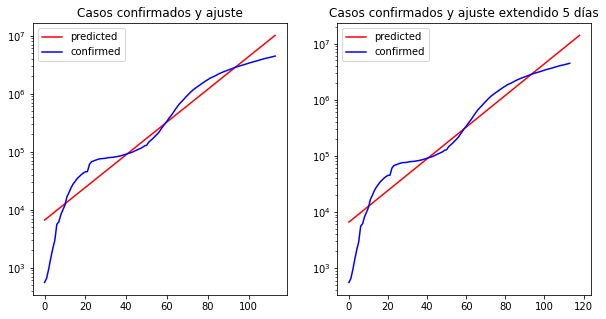

In [13]:
# Extraer parámetros resultantes y  sustituírlos adecuadamente
a, b = res.params
y = lambda x: np.exp(a) * np.exp(b) ** x # Usamos lambdas !
x_predicted = np.linspace(total_df.days.min(), total_df.days.max(), len(total_df.days))
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x_predicted, y(x_predicted), 'r-', label="predicted")
ax[0].plot(total_df.days, total_df['confirmed'], 'b-', label="confirmed")
# Predicción con 5 días en el futuro
x_predicted = np.linspace(total_df.days.min(), total_df.days.max()+5, len(total_df.days))
ax[1].plot(x_predicted, y(x_predicted), 'r-', label="predicted")
ax[1].plot(total_df.days, total_df['confirmed'], 'b-', label="confirmed")
# Títulos
ax[0].set_title("Casos confirmados y ajuste")
ax[1].set_title("Casos confirmados y ajuste extendido 5 días")
# Fix labels
for ax in fig.axes:
    plt.sca(ax)
    #plt.xticks(rotation=45)
    plt.yscale("log")
    plt.legend()

NOTA: Casi todas las escalas Y son logarítmicas, observar con cuidado cada una antes de hacer juicios.

Esta es una de las primeras gráficas que quería ver, de hecho con esto inicié el notebook, y rápidamente me di cuenta que aunque estamos en una buena etapa para ajustar los datos con una ecuación simple de crecimiento exponencial, es obvio que hay mucho ruido tanto de las fuentes de datos como del comportamiento no ideal del bicho. 

La segunda gráfica es la predicción con 5 días en el futuro, la empecé a ver cuando el número de casos era de unos 300 mil creo, llegar al millón se veía a un par de semanas. Eventualmente pasamos el millón y creo que 13 días después llegamos a los 2 millones el día de hoy (15-04-2020).

Veo con un poco de optimismo que la curva parece empezar apenas a "aplanarse", estoy casi seguro que en unos días ya va a ser evidente que ya no aplica la exponencial y se requiere un método más complicado para describir el comportamiento, eso significa que tengo que trabajar en ello !!

## Análisis de casos por día

La siguiente gráfica es "la derivada numérica de los datos", en otras palabras la diferencia de casos confirmados entre cada día.

In [14]:
# Ajuste lineal a los últimos 28 días
days = range(total_df.confirmed.count()-28+1, total_df.confirmed.count()+1)
confirmed = np.diff(total_df.confirmed)[-29:-1]
#list(days), confirmed
fit = np.polyfit(days, confirmed, 1)
f = np.poly1d(fit)
f(days)
fit

array([   86.07006021, 73192.60180624])

In [15]:
print("(Promedio, Desviación estándar)")
np.mean(confirmed),np.std(confirmed)

(Promedio, Desviación estándar)


(81842.64285714286, 6902.329509532507)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 9 Text major ticklabel objects>)

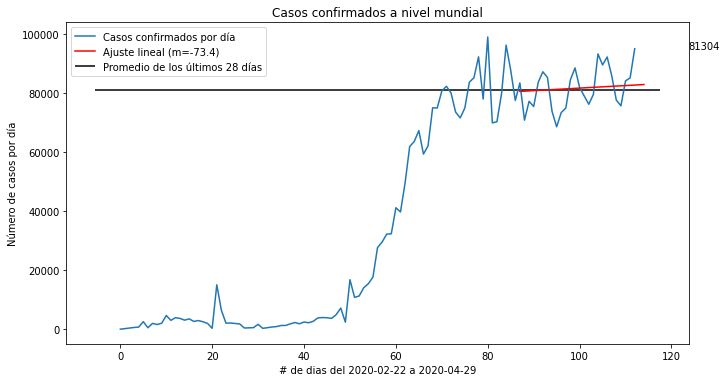

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.diff(total_df.confirmed), label="Casos confirmados por día")

#plt.yscale("log")
ax.hlines(np.diff(total_df.confirmed)[-28:-1].mean().astype(int), plt.xlim()[0], plt.xlim()[1], label="Promedio de los últimos 28 días")
plt.annotate(np.diff(total_df.confirmed)[-28:-1].mean().astype(int), (plt.xlim()[1], np.diff(total_df.confirmed)[-1]))
plt.tight_layout()
plt.plot(days, f(days), "r-", label="Ajuste lineal (m=-73.4)")
ax.set_title("Casos confirmados a nivel mundial")
plt.xlabel("# de dias del 2020-02-22 a 2020-04-29")
plt.legend()
_ =  plt.ylabel("Número de casos por día")
plt.xticks()#, plt.get_scale_docs()

Vemos en la gráfica anterior en azul los casos diarios (nuevos) confirmados desde el inicio de recopilación de datos de la fuente. En negro vemos el promedio de los últimos 28 días y en rojo el ajuste lineal a los datos de los últimos 28 días.

Hace unos 10 días la pendiente era negativa, pero ahora es positiva de nuevo, lo cual indica que estamos aflojando antes de tiempo las medidas de distanciamiento a nivel mundial.

Este tipo de observaciones van a tener que irse acumulando en el conocimiento científico para que podamos tener una mejor respuesta antes este problema, y podamos estar listos para rebrotes o nuevas epidemias.

### Decesos

In [17]:
total_df.deaths.diff()

2020-01-22       NaN
2020-01-23       1.0
2020-01-24       8.0
2020-01-25      16.0
2020-01-26      14.0
               ...  
2020-05-10    3398.0
2020-05-11    3621.0
2020-05-12    5612.0
2020-05-13    5255.0
2020-05-14    5221.0
Name: deaths, Length: 114, dtype: float64

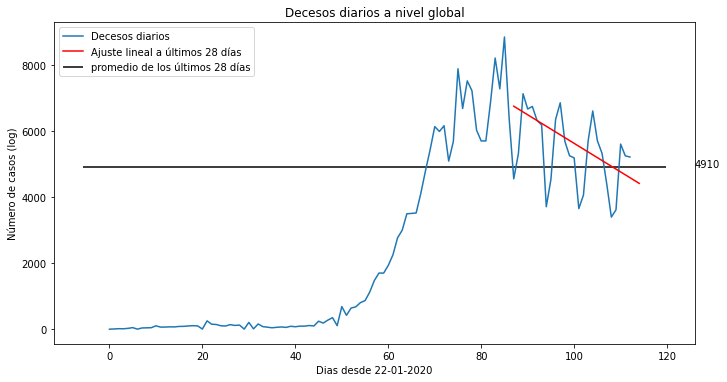

In [18]:
days = range(total_df.deaths.count()-28+1, total_df.deaths.count()+1)
deaths = np.diff(total_df.deaths)[-29:-1]
fit = np.polyfit(days, deaths, 1)
f = np.poly1d(fit)
#f(days), fit

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.diff(total_df.deaths), label="Decesos diarios")
plt.plot(days, f(days), "r-", label="Ajuste lineal a últimos 28 días")
#plt.yscale("log")
ax.hlines(np.diff(total_df.deaths)[-14:-1].mean().astype(int), plt.xlim()[0], plt.xlim()[1], label="promedio de los últimos 28 días")
plt.annotate(np.diff(total_df.deaths)[-14:-1].mean().astype(int), (plt.xlim()[1], np.diff(total_df.deaths)[-14:-1].mean().astype(int)))
plt.tight_layout()
ax.set_title("Decesos diarios a nivel global")
plt.xlabel("Dias desde 22-01-2020")
plt.legend()
_ =  plt.ylabel("Número de casos (log)")

A 15 de mayo esta gráfica mejora las expectativas, en el caso de decesos tenemos una pendiente negativa, y bastante marcada, ya bajó de 5 mil decesos diarios el promedio, y pareciera que va a seguir así, a este paso podríamos estar cerca de cero un par de meses.


## Ajuste polinomial
Creo que ya no es relevante hacer ajustes, al menos de este tipo, los quito, y veré si me doy tiempo de hacer algo más adecuado, en este momento lo más importante es ver que los casos caigan y que no tengamos rebrotes, lo cual se ve en las otras gráficas.

In [19]:
# p = np.polyfit(total_df["days"].array, total_df["confirmed"].array,5) # 5to grado
# x = np.linspace(total_df.days.min(), total_df.days.max(),50)
# f = np.poly1d(p)

# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,5))

# total_df['poly'] = f(total_df.days) #Agregando el ajuste al DF
# total_df.plot( y=["confirmed", "poly"], fig=fig, ax = ax1)
# x = np.linspace(total_df.days.min(), total_df.days.max(),50)
# ax2.plot(x, f(x), 'r-')
# x = np.linspace(total_df.days.max(), total_df.days.max()+10,10)
# ax2.plot(x, f(x), 'c--', label='pred-10-days')
# ax2.plot(range(total_df["confirmed"].count()), total_df["confirmed"], label='confirmed')
# #leg = ax2.legend()
# for ax in fig.axes:
#     plt.sca(ax)
#     #plt.xticks(rotation=45)
#     plt.ylabel("# de Casos")
#     plt.xlabel("Dias a partir del primer caso confirmado")
#     plt.legend()
#     plt.yscale("log")

## Decesos y recuperados
Afortunadamente hemos llegado a un momento en el que el número de decesos ya no está en aumento en varios países, todavía le falta unos meses al resto del mundo, pero ya tenemos una buena cantidad de países que van en bajada o de plano ya llegaron a números muy bajos diarios y periodos sin ningún deceso relacionado con covid19.

Viendo la siguiente gráfica podemos ver una ligera inclinación al final de la curva de decesos que nos puede dar la indicación de que la pendiente va a ir bajando hasta que lleguemos a un número global de nuevos decesos muy bajo, todavía estamos algo lejos de eso con 5 mil decesos diarios en promedio para los últimos 28 días, pero es esperanzador el comportamiento actual, esperemos en unas semanas tener un promedio mucho menor.

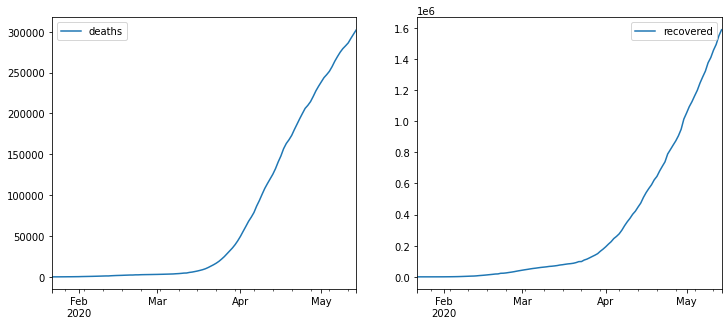

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
total_df.plot(y=["deaths"], ax=ax[0])
total_df.plot(y=["recovered"], ax=ax[1])
for ax in fig.axes:
    plt.sca(ax)
    #plt.yscale("log")
    plt.legend()

Afortunadamente el número de casos recuperados va a la alza, y el números de decesos no parece ir tan rápido como el de casos confirmados

## Países con más casos (min_confirmed=20000)

Ahora vamos a expulgar un poco más, tomamos el registro más reciente de cada país filtrando los que tienen más de `min_confirmed` casos confirmados para tener el total de cada país:

In [21]:
min_confirmed = 20000
day = country['Mexico'].index[-1].strftime("%Y-%m-%d") # Last day for any of the countries
print(day)
country_day = {}
for k in data.json().keys():
    country_day[k] =  country[k].loc[day]#["confirmed"]

2020-05-14


Pasamos el diccionario a un DataFrame para graficar fácilmente los datos (vamos a usar ese truco casi en todos los casos):

In [22]:
country_day = pd.DataFrame.from_dict(country_day, orient='index', columns=["confirmed", "recovered", "deaths"])

In [23]:
country_day.head()

,confirmed,recovered,deaths
Afghanistan,5639,691,136
Albania,898,694,31
Algeria,6442,3158,529
Andorra,761,596,49
Angola,48,14,2


In [24]:
country_day.sort_values("confirmed", ascending=False).head(20)

,confirmed,recovered,deaths
US,1417774,246414,85898
Russia,252245,53530,2305
United Kingdom,234440,1043,33693
Spain,229540,143374,27321
Italy,223096,115288,31368
Brazil,203165,79479,13999
France,178994,59719,27428
Germany,174478,150300,7884
Turkey,144749,104030,4007
Iran,114533,90539,6854


Y pues nada, Estados Unidos por mucho se mantiene con más casos confirmados y vemos abajo que igualmente en decesos, es bastante obvio que su manejo es muy malo.

In [25]:
country_day.sum()

confirmed    4442163
recovered    1587893
deaths        302418
dtype: int64

In [26]:
country_day.sort_values("deaths", ascending=False).head(20)

,confirmed,recovered,deaths
US,1417774,246414,85898
United Kingdom,234440,1043,33693
Italy,223096,115288,31368
France,178994,59719,27428
Spain,229540,143374,27321
Brazil,203165,79479,13999
Belgium,54288,14111,8903
Germany,174478,150300,7884
Iran,114533,90539,6854
Netherlands,43680,159,5609


## Número de países con muchos casos (*más* de `20000` casos confirmados):

Y su distribución por porcentajes, disculpen el traslape de etiquetas:

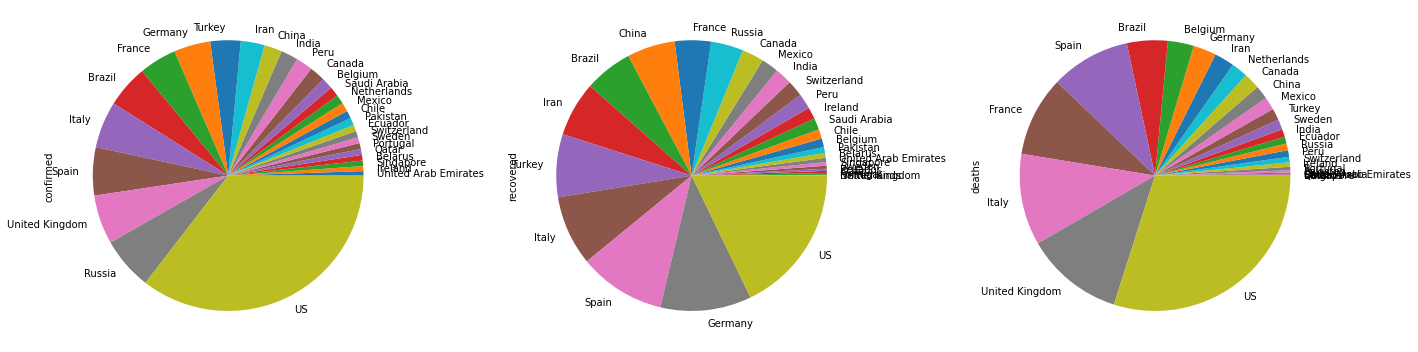

In [27]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
country_day_top = country_day[country_day['confirmed'] > min_confirmed]
country_day_top['confirmed'].sort_values().plot(kind='pie', ax = ax[0])#, figsize=(15,15))
country_day_top['recovered'].sort_values().plot(kind='pie', ax = ax[1])#, figsize=(15,15))
country_day_top['deaths'].sort_values().plot(kind='pie', ax = ax[2])#, figsize=(15,15))
plt.tight_layout()

In [28]:
country_day_top["confirmed"].count()

29

México ya está en el lugar 18 de de casos confirmados y en el 15 por decesos.

In [29]:
country_day_top.loc["Mexico"]

confirmed    42595
recovered    28475
deaths        4477
Name: Mexico, dtype: int64

## Número de países con números intermedios (*menos* de 20000 y más de 1000 casos confirmados):

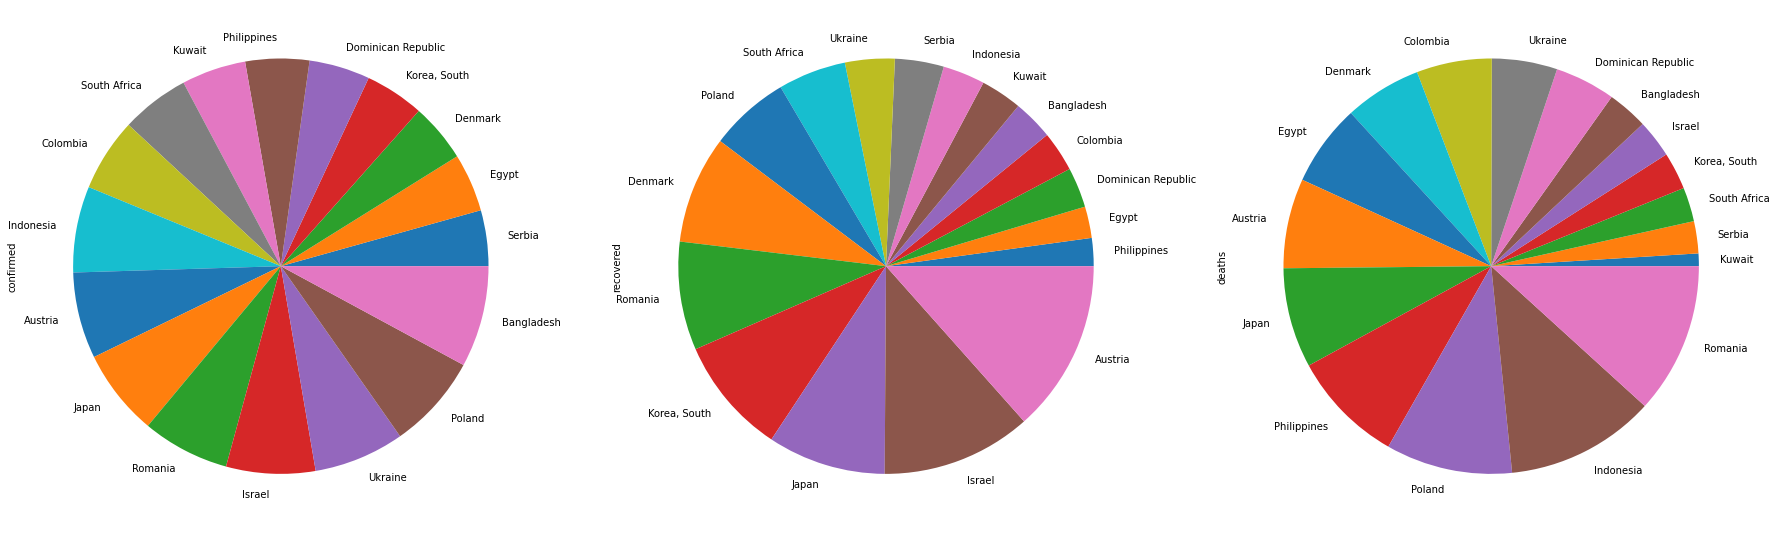

In [30]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
country_day_middle = country_day.query("confirmed <= 20000 & confirmed > 10000")
country_day_middle['confirmed'].sort_values().plot(kind='pie', ax = ax[0])
country_day_middle['recovered'].sort_values().plot(kind='pie', ax = ax[1])
country_day_middle['deaths'].sort_values().plot(kind='pie', ax = ax[2])
plt.tight_layout()

In [31]:
country_day_middle["confirmed"].count()

17

La distribución de casos confirmados es bastante uniforme, pero no las de casos recuperados y la de defunciones.

Creo que la diferencia de orden de los países en la primera y tercera gráfica debe tener mucho que ver con la cantidad de pruebas que se hacen, el único país que está en los primeros lugares en ambas gráficas es Japón.

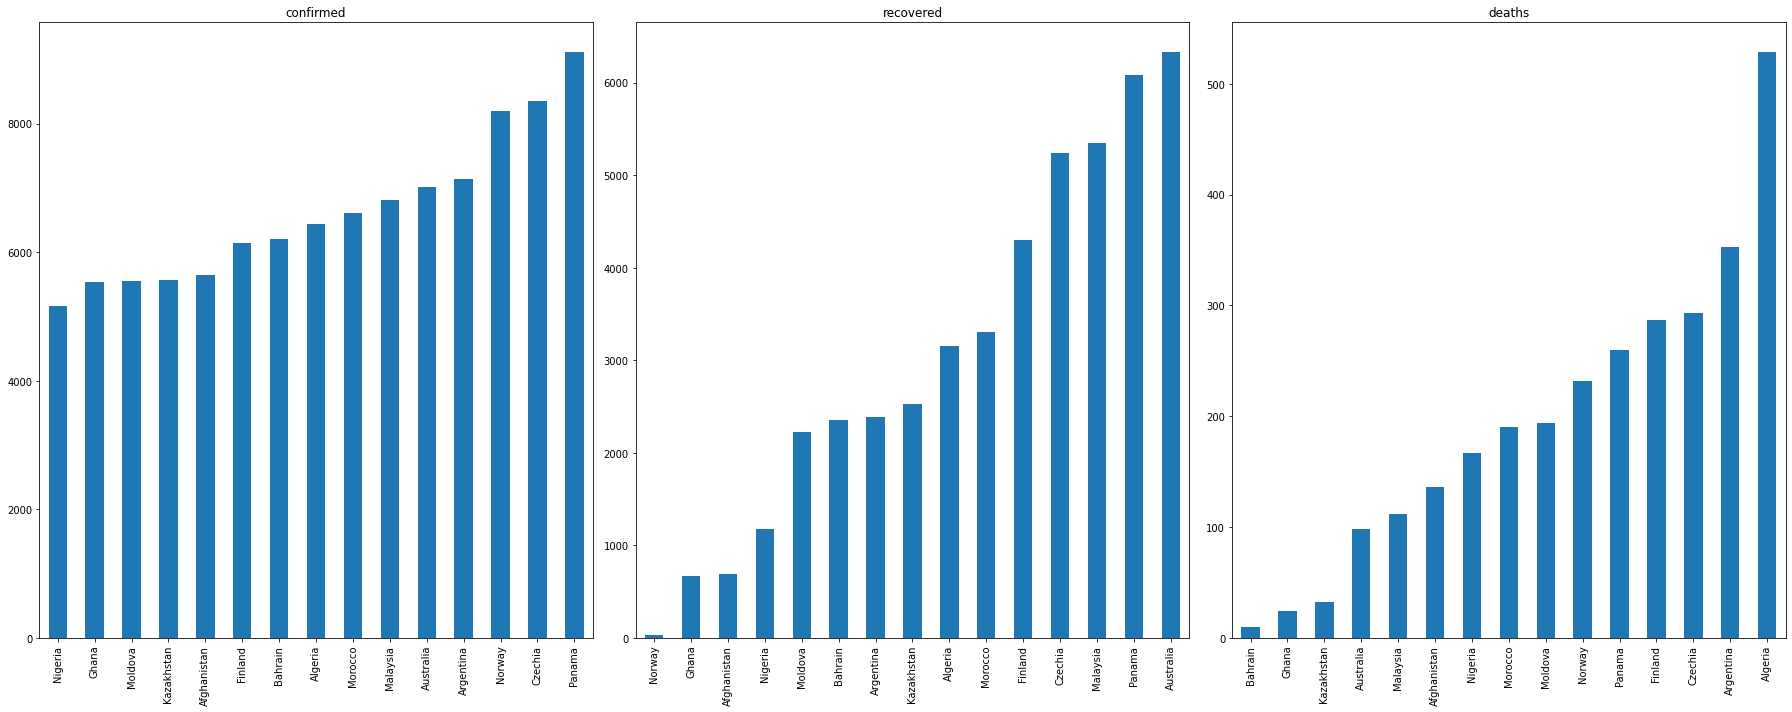

In [32]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
country_day_middle = country_day.query("confirmed <= 10000 & confirmed > 5000")
country_day_middle['confirmed'].sort_values().plot(kind='bar', ax = ax[0], title="confirmed")
country_day_middle['recovered'].sort_values().plot(kind='bar', ax = ax[1], title="recovered")
country_day_middle['deaths'].sort_values().plot(kind='bar', ax = ax[2], title="deaths")
plt.tight_layout()

## Número de países con pocos casos (Menor o igual a 1000):

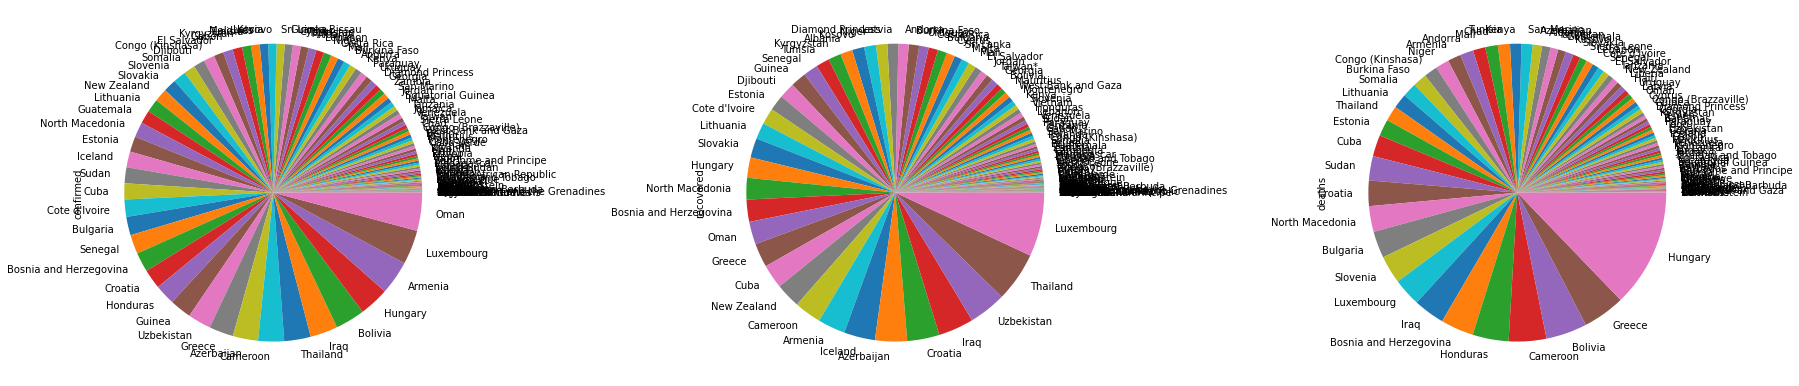

In [33]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
country_day_bottom = country_day.query("confirmed <= 5000")
country_day_bottom['confirmed'].sort_values().plot(kind='pie', ax = ax[0])
country_day_bottom['recovered'].sort_values().plot(kind='pie', ax = ax[1])
country_day_bottom['deaths'].sort_values().plot(kind='pie', ax = ax[2])
plt.tight_layout()

In [34]:
country_day_bottom["confirmed"].count()

127

## Distribución en histograma de número de países por número de casos
La distribución está muy centrada en valores por debajo de 1000 casos (ver tercer histograma, solo hay menos de 10 países que claramente entraron en una fase avanzada de casos. He visto comentarios de que se estima que podría infectarse el 70% de la población, por lo que deberíamos esperar que esa distribución se haga mucho más amplia con el paso de los meses.

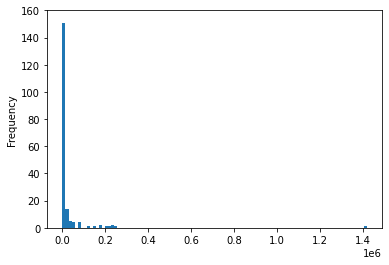

In [35]:
country_day["confirmed"].plot(kind="hist", bins=100, ylim=(0,160))

La distribución general básicamente no aporta información, la inmensa mayoría de los países van iniciando, yo esperaría que después de unos 3-6 meses la distribución esté centrada dentro de los 100 mil o más casos por país por lo menos. USA hace que la distrubición esté cada vez más extendida, pero la diferencia entre su número y el segundo lugar es enorme.

### Misma gráfica con menos divisiones

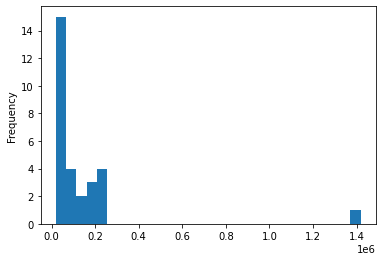

In [36]:
country_day_top["confirmed"].plot(kind="hist", bins=30)

Creo que ya es tiempo de remover USA de esta gráfica:

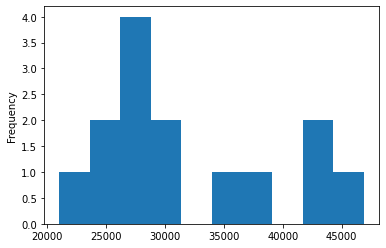

In [37]:
country_day_top.query("confirmed < 50000")["confirmed"].plot(kind="hist", bins=10)

Y sí, todavía nos falta para que esto se vea uniforme.

### Países con menos de 5000 casos y más de 1000

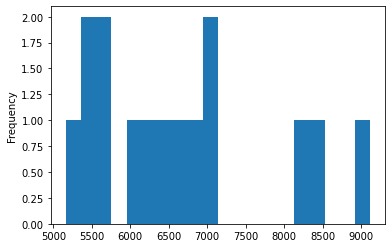

In [38]:
country_day_middle["confirmed"].plot(kind="hist", bins=20)

Que distribución tan extraña, obviamente el muestreo deja mucho que desear aquí.

### Países con menos de 1000 casos

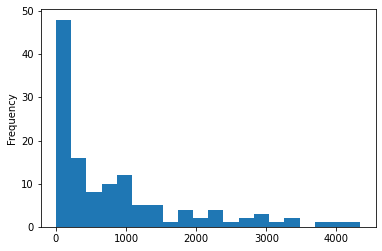

In [39]:
country_day_bottom["confirmed"].plot(kind="hist", bins=20)

Tenemos en estos momentos más de 50 países con menos de 250 casos, creo que es un buen número general, esperemos que muchos de ellos simplemente se queden ahí en esta etapa y que eventualmente en estudios adecuados se confirme que ya alcanzaron la inmunidad de rebaño sin tener que pasar por una crisis.

# Número de casos como línea de tiempo por grupos de países

La siguiente función devuelve 4 gráficas de línea de tiempo para la lista de países con los números de enfermos confirmados, un estimado del número de casos activos, una de decesos registrados y una de porcentaje de decesos con respecto a los detectados. Acepta un argumento que es la lista de nombres de países que se quiere graficar.

In [40]:
def plot_timeline(c_list = ["Mexico"], figsize=(20,7)):
    fig, ax = plt.subplots(1,4, figsize=figsize)
    plt.xticks(rotation=45)
    for c in c_list:
        ax[0].plot(country[c]["2020-01":]["confirmed"], label=c)
        ax[1].plot(country[c]["2020-01":]["confirmed"] - 
                   country[c]["2020-01":]["recovered"] - 
                   country[c]["2020-01":]["deaths"], label=c)
        ax[2].plot(country[c]["2020-01":]["deaths"], label=c, linestyle="-")
        ax[3].plot(country[c]["2020-01":]["deaths"]/country[c]["2020-01":]["confirmed"]*100, label=c, linestyle="-")
        
        ax[0].set_title("Confirmed")
        ax[1].set_title("Active")
        ax[2].set_title("Deaths")
        ax[3].set_title("% of deaths")
    #if ax[3].set_ylim()[1] > 20: # fix for Iran % of deaths plot.
    #    ax[3].set_ylim([-1, 20])
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=45)
        plt.legend()
        plt.yscale("log")
        plt.ylabel("Casos")

## Mexico / Korea del Sur / Singapur / Suecia / Rep. Checa / Suiza
Países que me interesan por su contexto parecido al de México y la esperanza de que tengamos resultados positivos (a diferencia de la mayoría de los países del Top 10, por ejemplo).

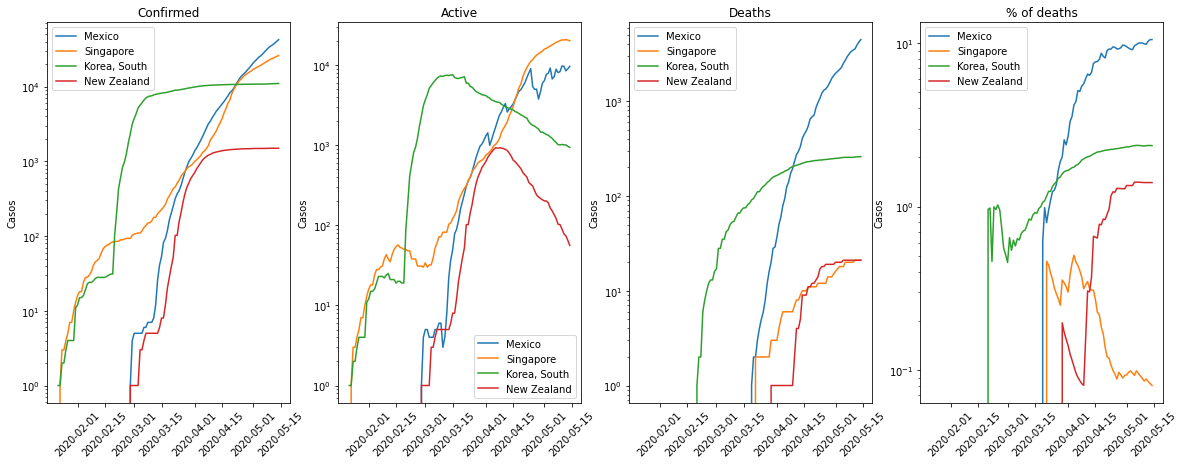

In [41]:
c_list = ["Mexico","Singapore", 
          "Korea, South", 
          "New Zealand"]
plot_timeline(c_list)

Corea claramente hizo lo necesario para su contexto. Nueva Zenanda definitivamente hizo muy buen trabajo. Singapur pudo mantenerse con números bajos mucho tiempo, y sigue teniendo un número de decesos muy bajo, aunque los casos confirmados son similares a los de México que poco a poco (y muy rápido en las últimas 4 semanas) ha ido aumentando el número de casos y decesos, al grado de que casi tenemos 10% de decesos con más de mil decesos en este momento, es un número bastante preocupante. 

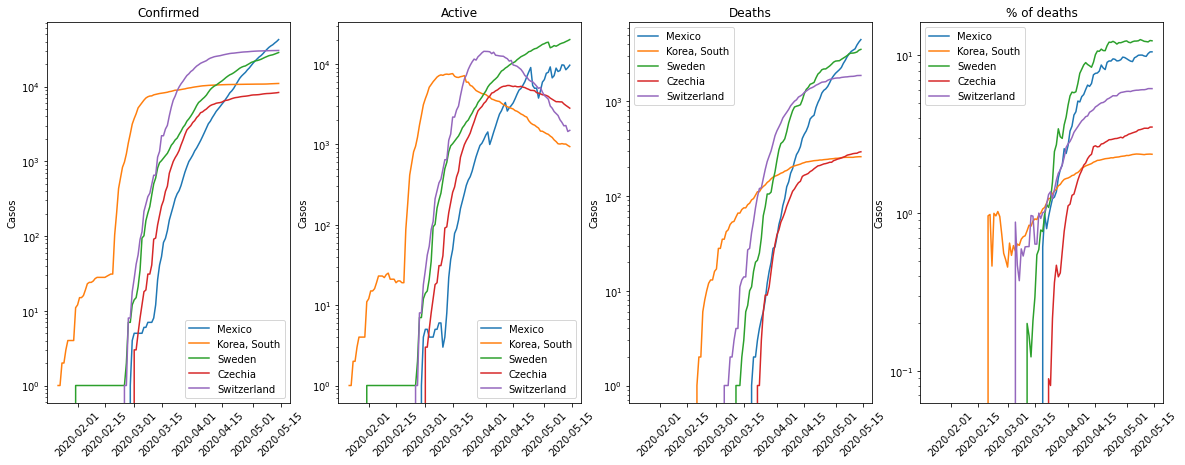

In [42]:
c_list = ["Mexico", "Korea, South", "Sweden", "Czechia", "Switzerland",]
plot_timeline(c_list)

Rep. Checa es otro país mencionado como buen manejador de la epidemia, al momento pareciera que va a llevar un comportamiento similar a Suecia, en el que la confianza al principio mantiene las cosas tranquilas, pero al momento de entrar a fase 2 hay que reaccionar activamente muy rápido y dejar atrás los intentos de mantener todo normal.

Pareciera que Rep. Checa está logrando aplanar la curva, y parece que están llegando a una fase de control.

México desafortunadamente lleva un comportamiento bastante similar al de Suecia y Suiza, esto es algo que debería tomarse en cuenta para apretar las medidas de contención.

Contrastando los números globables con los de México me pareciera que vamos un par de semanas atrás, por lo que pensaría que volver a actividades debería hacerse a partir de junio, oficialmente se supone que empezamos a retomar actividades en 17 de mayo en los lugares con pocos casos, y al final de mayo en el resto del país, así que la proyección oficial suena sensata, pero para que todo funcione requerimos que en las siguientes semanas se aplane la curva y de preferencia que empecemos a ver al menos signos de disminución de nuevos casos y decesos. Cosa que al 24 de abril no parece suceder.

## México, Francia, Suecia...

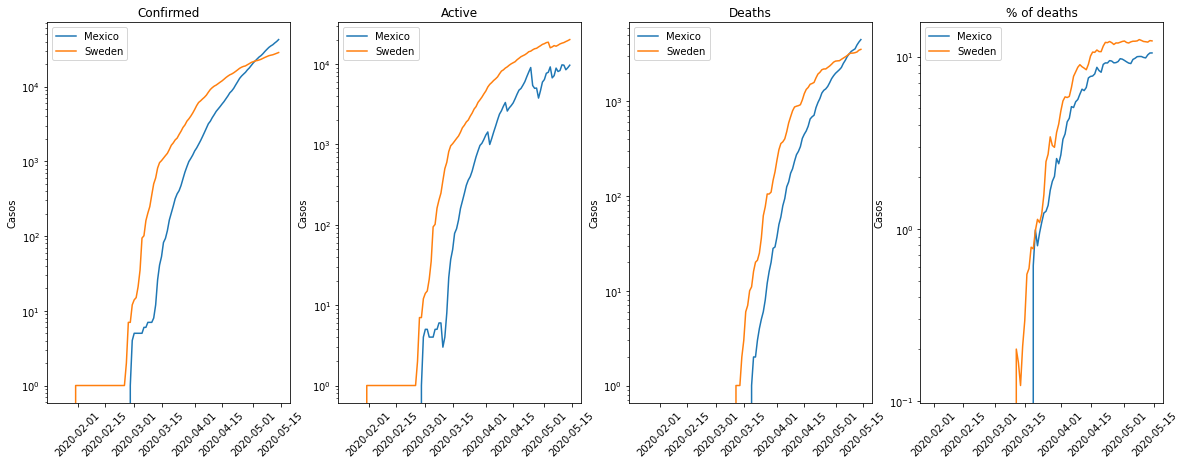

In [43]:
c_list = ["Mexico", "Sweden"]
plot_timeline(c_list)

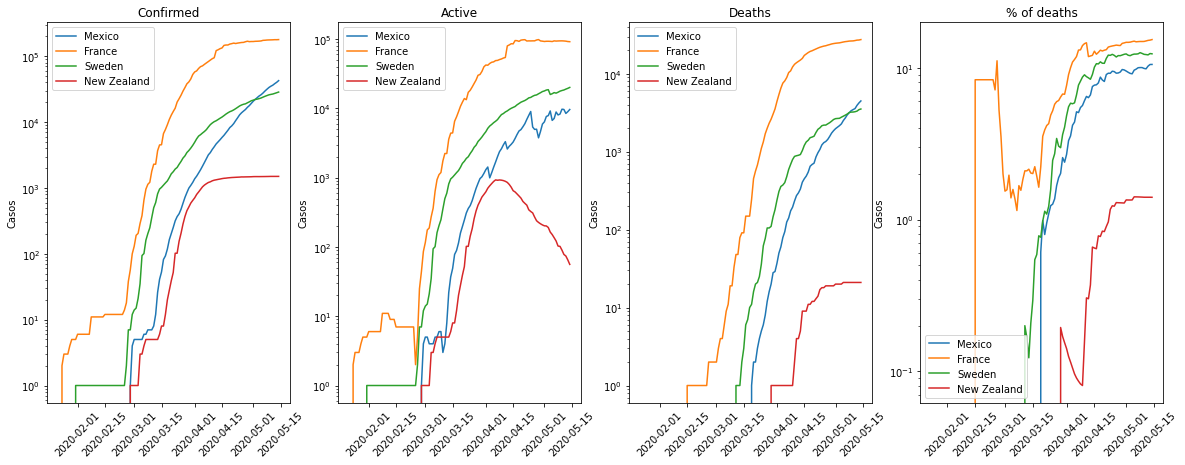

In [44]:
c_list = ["Mexico", "France", "Sweden", "New Zealand"]
plot_timeline(c_list)

## Tablas de datos para México

In [45]:
#country["Mexico"].drop(index="2020-05-06", inplace=True)

In [46]:
# Fixing 2020-04-24 data
#country["Mexico"].loc["2020-05-06 00:00:00"] = (27634, 2704, 16810)
#country["Mexico"].tail()

In [47]:
country["Mexico"].tail(20)

,confirmed,deaths,recovered
date,,,
2020-04-25,13842,1305,7149
2020-04-26,14677,1351,8354
2020-04-27,15529,1434,9086
2020-04-28,16752,1569,11423
2020-04-29,17799,1732,11423
2020-04-30,19224,1859,11423
2020-05-01,20739,1972,12377
2020-05-02,22088,2061,12377
2020-05-03,23471,2154,13447


Esta semana es la que se pronostica como peor para México, los números hablan por sí solos, todavía seguimos teniendo número récord de casos nuevos, pero las oscilaciones en el número de decesos nos pueden dar cierta seguridad de que se está llegando a una estabilización de la curva (se está aplanando), probablemente necesitamos un par de semanas para empezar a ver un comportamiento de disminución, y en particular el mismo comportamiento se debe ver en los casos confirmados, ya que en este momento no es tan claro como para los decesos.
<!--En los últimos dos días México ha aumentado alarmantemente sus números, pasamos de tener un record de 764 casos un par de días antes a más de 2200 casos, y de la misma forma el número de decesos despues de unos días de estabilidad aumentó a más de 200 los últimos dos días, esto es una mala señal.
--> 
<!--Tenemos ya más de 400 casos nuevos al día, y 40 muertos, en números totales México tiene ya el 6% de decesos con respecto a los casos comprobados, ambos números son aproximados, sabemos incluso por la apreciación oficial que estos números no son necesariamente cercanos a los reales, pero aún así es algo preocupante que el número de muertes nuevas por día sigue aumentando.

Y al parecer sí vamos aplanando la curva también, las gráficas correspondientes se ven así:
-->

<!-- Las cosas se ven mal en este momento, tenemos 202 nuevos casos y 19 decesos, no es que sea totalmente correcto comparar así pero a este paso vamos a llegar al 10% de decesos comparado contra los detectados totales. En el siguiente grupo de gráficas vemos que Italia, Alemania y Francia andan sobre 10%, así que desafortunadamente no suena descabellado que países como México lleguen a esos números en cuestión de decesos. -->

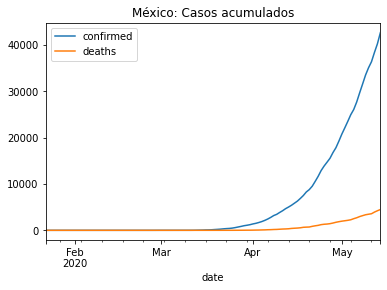

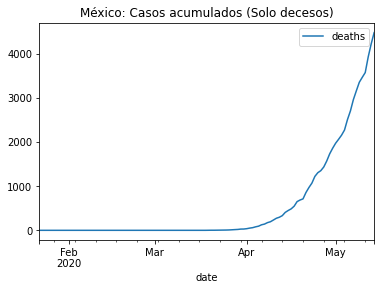

In [48]:
country["Mexico"][["confirmed","deaths"]].plot(title="México: Casos acumulados")
country["Mexico"][["deaths"]].plot(title="México: Casos acumulados (Solo decesos)")
#plt.yscale("log")

Text(0, 0.5, 'Fecha')

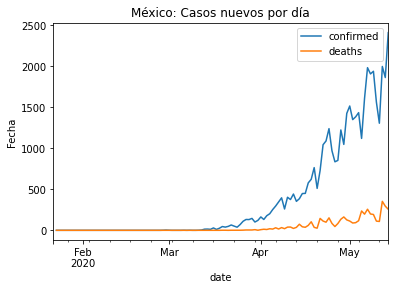

In [49]:
country["Mexico"].diff()[["confirmed","deaths"]].plot(title="México: Casos nuevos por día")
plt.ylabel("Casos")
plt.ylabel("Fecha")
#plt.yscale("log")

Ya pasamos la semana predicha para el pico y los números recientes parecen indicar que realmente todavía no superamos la meseta del máximo, tanto en casos nuevos como en decesos tenemos un nuevo máximo, vamos a ver los siguientes días, este tipo de dato es el que se requiere tomar en cuenta para apretar medidas o relajarlas, no parece que debamos aflojarlas todavía, pero estamos a un par de semanas de que se inicie el regreso a la "nueva normalidad", así que esperemos que mejoren estos números en estas semanas.

Text(0, 0.5, 'Casos')

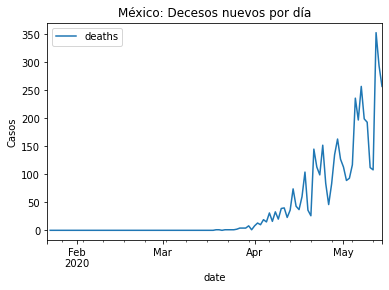

In [50]:
country["Mexico"].diff()[["deaths"]].plot(title="México: Decesos nuevos por día")
plt.ylabel("Casos")
#plt.yscale("log")

En decesos también tenemos un comportamiento similar, parece que sí vamos hacia abajo, pero las oscilaciones no son tan esperanzadoras, necesitamos más días para poder confirmar que pasamos el pico exitosamente.

## Países  en el top 5 de casos confirmados
Podemos crear listas manualmente, pero para estos casos simplemente podemos usar el DataFrame que tenemos para el último día registrado y de ahí sacar las listas interesantes automáticamente.

In [51]:
c_list = country_day.sort_values("confirmed", ascending=False).head(5).index
c_list

Index(['US', 'Russia', 'United Kingdom', 'Spain', 'Italy'], dtype='object')

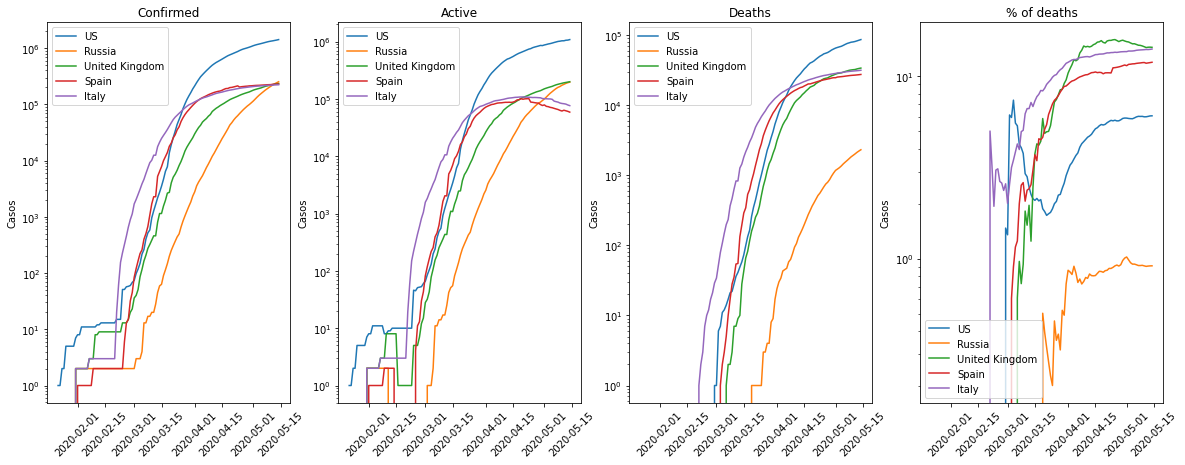

In [52]:
plot_timeline(c_list)

Poco a poco vamos viendo cómo se posicionan los países con peor manejo de la epidemia, ha habido mucho movimiento en esta lista, pero el que llegó para quedarse es Estados Unidos por lo que se ve hasta ahora.

## Países en el top 6-10 de casos confirmados

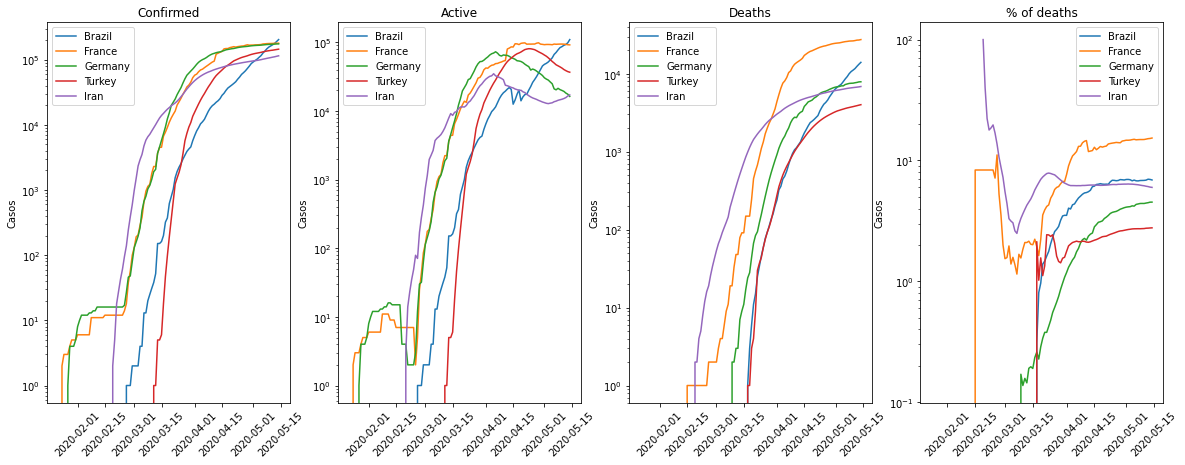

In [53]:
c_list = country_day.sort_values("confirmed", ascending=False).head(10).tail(5).index
plot_timeline(c_list)

La otra mitad del top 10 tampoco se ve bien. Irán me obligó a aplicar un límite condicional en el eje Y ya que sus números empiezan con 100% de decesos, lo cual arruina por completo la visualización del resto de los países.

Creo que todos estos países ya tienen una pendiente muy horizontal o de plano negativa, creo que solamente USA está todavía con una pendiente marcádamente positiva.

## Countries in the top 11-20 confirmed list

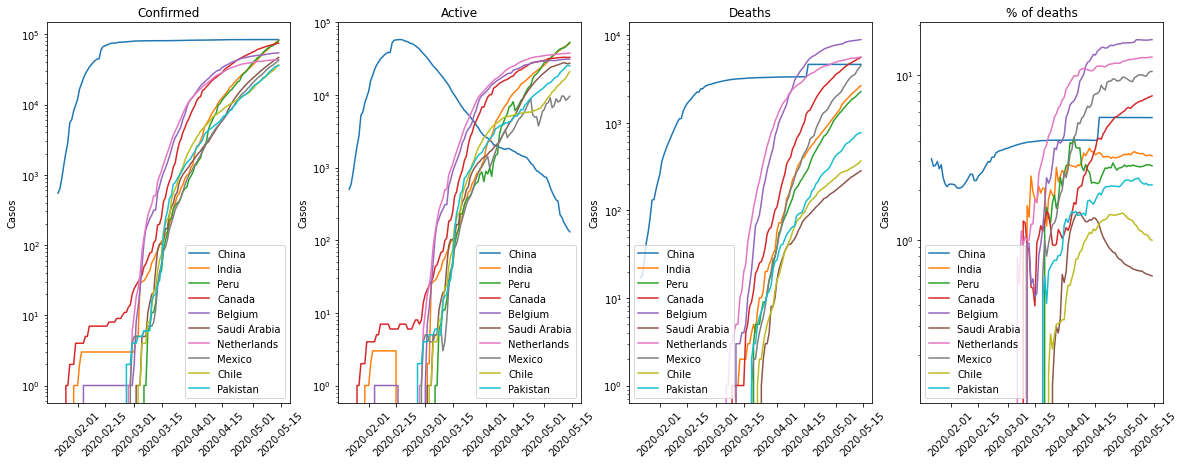

In [54]:
c_list = country_day.sort_values("confirmed", ascending=False).head(20).tail(10).index
plot_timeline(c_list)

Creo que solo China ha superado la crisis en este grupo, vemos como ha ido cayendo posiciones en la tabla, yo pensaría que a este grupo de países les falta 1 o 2 meses para llegar al punto en que está China.

## Países con entre 500 y 1000 casos
Hay una distribución amplia de números, pero en general todos van sobre un comportamiento similar, exceptuando el barco "Diamond Princess" que veremos abajo.

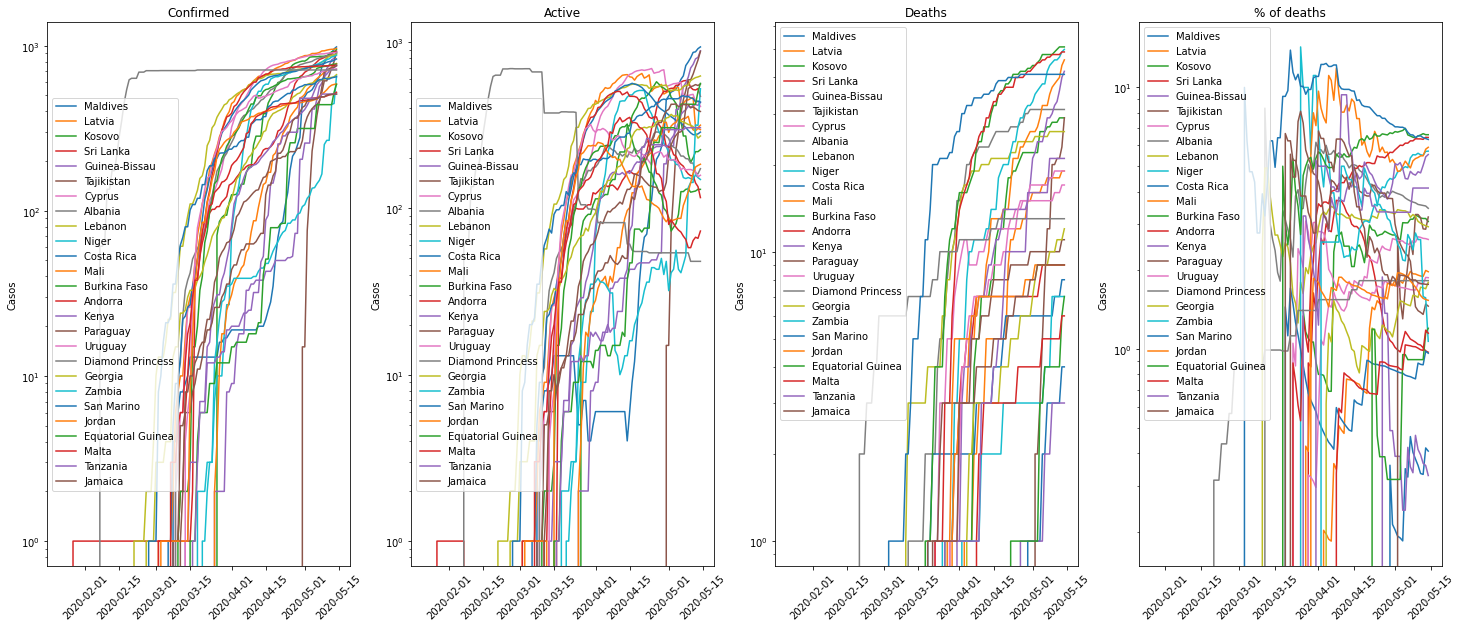

In [55]:
c_list = country_day.query("confirmed > 500 & confirmed < 1000 ").sort_values("confirmed", ascending=False).index
plot_timeline(c_list, figsize=(25,10))

## Diamond Princess 

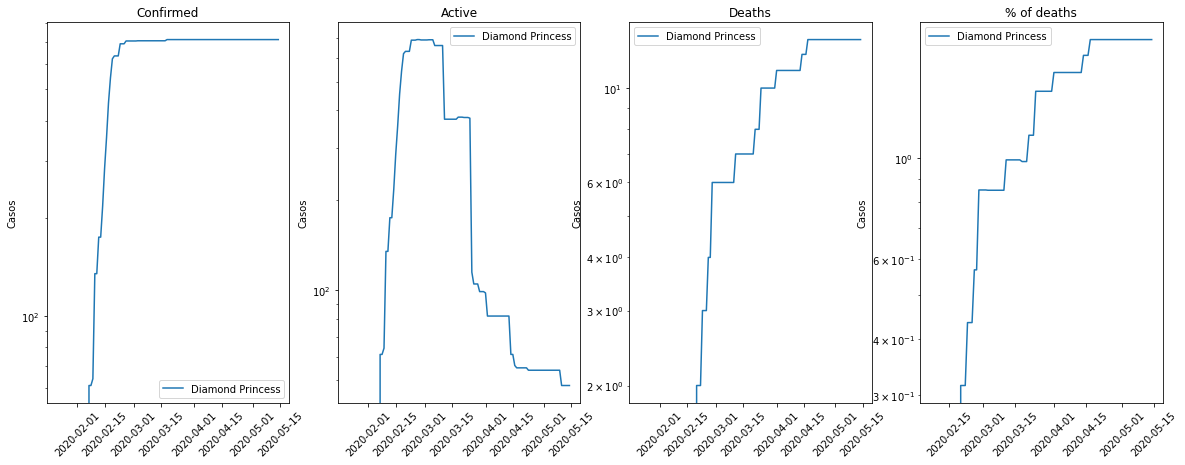

In [56]:
plot_timeline(["Diamond Princess"])

Es todo un caso pero no sabía mucho al respecto, aparentemente sí fueron evacuados por ahí del 1 de marzo las últimas personas, la discusión está en si fue bueno o no aplicar la cuarentena, por los números yo diría que sí, aunque siempre hay espacio para hacer las cosas mejor, creo que la parte fea fue el mantener a las personas encerradas en el barco, debe ser una experiencia bastante desagradable.

# Datos del país normalizados al día-cero 
Hoy 2020-04-05 voy a mover la normaización al primer día con más de 499 casos, y en unos días más lo moveré a 1000 para empezar a ver números más "estables" y mejores ajustes ahora que hemos avanzado unas semanas más los países que apenas vamos en las primeras semanas de crisis.

In [57]:
def get_country(data, country='Mexico', min_cases=499, column="confirmed"):
    data_df = pd.DataFrame(data.json()[country],)
    data_df['date'] = pd.to_datetime(data_df['date'])
    data_df = data_df[data_df["confirmed"] > min_cases ]
    min_sec = time.mktime(data_df['date'].min().timetuple())
    data_df['seconds'] = [time.mktime(t.timetuple()) - min_sec for t in data_df.date]
    data_df['days'] = data_df['seconds'] / 86400
    return data_df[["days", column]].set_index("days")

In [58]:
# Example: Mexico data
mx = get_country(data, country='Mexico')
mx.head()

,confirmed
days,
0.0,585
1.0,717
2.0,848
3.0,993
4.0,1094


## Uniendo dataframes normalizados para la lista de países deseada

In [59]:
def merge_country(data, suffixes=["_mx", "_ks"], c_list=["Mexico", "Korea, South"], column="confirmed"):
    if len(c_list) != len(suffixes):
        raise "Both c_list and suffixes need to have same length"
    df = get_country(data, country=c_list.pop(0), column=column)
    s = suffixes.pop(0)
    for i in range(len(c_list)):
        df = pd.merge(df, get_country(data, country=c_list[i], column=column), how="outer", suffixes=[s, suffixes[i]], on="days") #first two
        df.rename(columns={column: "{}{}".format(column, suffixes[i])}, inplace=True) # Rest of them
    return df    

## Comparando México con Corea del Sur y Suecia

Son los dos países que se ponen como ejemplo en las noticias, Suecia parece que de pronto saltó de ser el ejemplo a no serlo, pero lo veremos más claro en unos días.

Eliminé a USA porque es el primer lugar mundial en casos y solo hace ruido en la gráfica. Por razones similares quito España, Francia e Italia, los veremos en un subgrupo aparte, ya están muy lejos del comportamiento de México que es el que más me interesa ver.

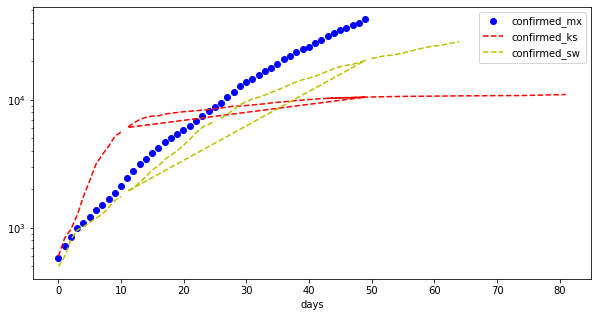

In [60]:
s = ["_mx"    , "_ks"         , "_sw"]
cl = ["Mexico", "Korea, South", "Sweden"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,15), ylim=(0,5000))
plt.yscale("log")

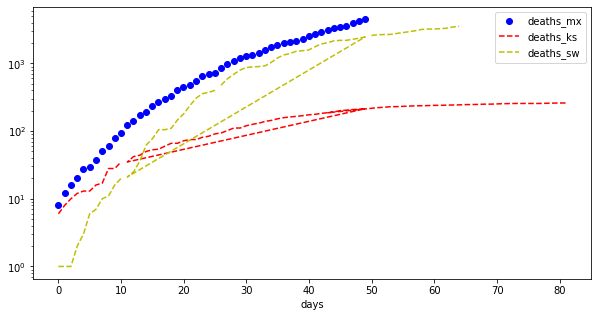

In [61]:
s = ["_mx"    , "_ks"         , "_sw"]
cl = ["Mexico", "Korea, South", "Sweden"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="deaths")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))
plt.yscale("log")

## Agregando Singapur y Rep. Checa como buen ejemplo

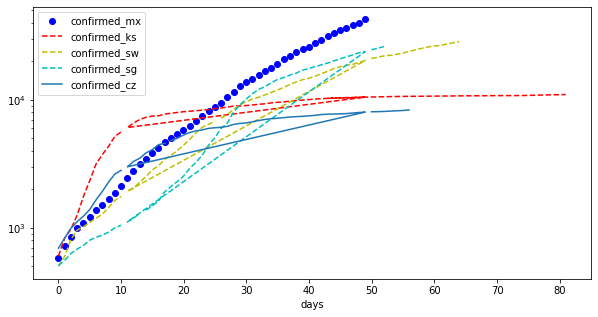

In [62]:
s = ["_mx"    , "_ks"         , "_sw"   , "_sg"      , "_cz"]
cl = ["Mexico", "Korea, South", "Sweden", "Singapore", "Czechia"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))
plt.yscale("log")

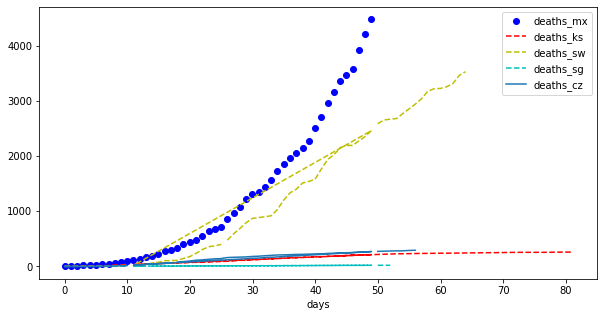

In [63]:
s = ["_mx"    , "_ks"         , "_sw"   , "_sg"      , "_cz"]
cl = ["Mexico", "Korea, South", "Sweden", "Singapore", "Czechia"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="deaths")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))

Definitivamente Singapur va muy bien, ha logrado estar más de 2 meses sin pasar a fase 2. Suecia estuvo cerca pero no lo logró, Corea del Sur tuvo 1 mes en fase 1, y México solo 20-25 días, y el último agregado Rep. Checa tuvo también unos 20 días de fase 1 y ahora va más rápido que México, aunque con menos decesos.

Nota: México aparentemente está haciendo pocas pruebas de tal manera que sus números confirmados seguramente son bastante menores de los reales, pero el número de muertes por Covid-19 es mucho más confiable, es algo a considerarse en el análisis de los datos oficiales. Estoy seguro que no somos el único país en esa situación, por lo que el error más o menos se elimina en las comparaciones.

## Otra conjunto de países "interesantes"
Los he visto muy mencionados en noticias, seguro en los próximos días y semanas se moverán mucho los países más mencionados al respecto del covid-19. 

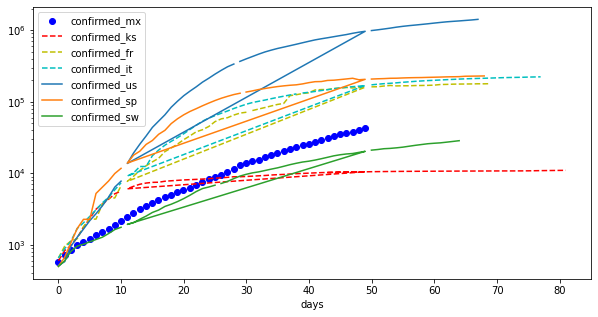

In [64]:
s = ["_mx"    , "_ks"         , "_fr"   , "_it"  , "_us", "_sp"  , "_sw"]
cl = ["Mexico", "Korea, South", "France", "Italy", "US", "Spain", "Sweden"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
#display(cgroup.tail())
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))
plt.yscale("log")

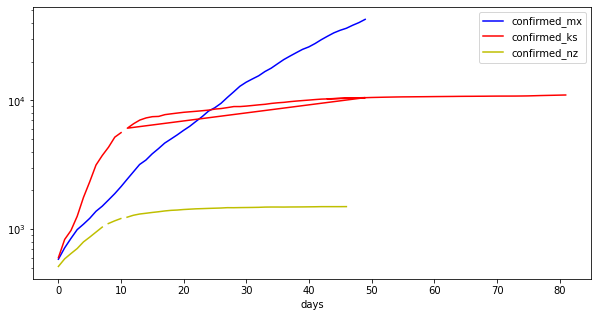

In [65]:
s = ["_mx"    , "_ks"         , "_nz"]
cl = ["Mexico", "Korea, South", "New Zealand"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
#display(cgroup.tail())
cgroup.plot(figsize=(10,5), style = ['b-','r-','y-', 'c-'])#, xlim=(0,35), ylim=(0,1000))
plt.yscale("log")

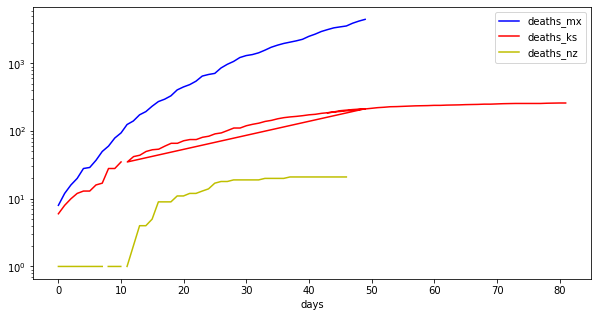

In [66]:
s = ["_mx"    , "_ks"         , "_nz"]
cl = ["Mexico", "Korea, South", "New Zealand"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="deaths")
#display(cgroup.tail())
cgroup.plot(figsize=(10,5), style = ['b-','r-','y-', 'c-'])#, xlim=(0,35), ylim=(0,1000))
plt.yscale("log")

## Revisando China por las últimas noticias de que hay repunte de casos

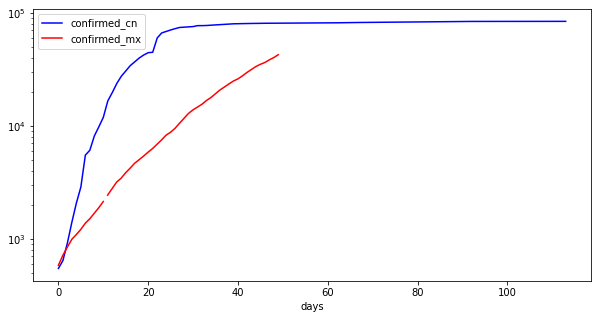

In [67]:
s = ["_cn", "_mx"]
cl = ["China", "Mexico"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
cgroup.plot(figsize=(10,5), style = ['b-','r-','y-', 'c-'])#, xlim=(0,35), ylim=(0,1000))
plt.yscale("log")

In [68]:
cgroup.diff(periods=1).head(20)

,confirmed_cn,confirmed_mx
days,,
0.0,NaN,NaN
1.0,95.0,132.0
2.0,277.0,131.0
3.0,486.0,145.0
4.0,669.0,101.0
5.0,802.0,121.0
6.0,2632.0,163.0
7.0,578.0,132.0
8.0,2054.0,178.0


In [69]:
cgroup.diff().tail()

,confirmed_cn,confirmed_mx
days,,
44.958333,NaN,1562.0
45.958333,NaN,1305.0
46.958333,NaN,1997.0
47.958333,NaN,1862.0
48.958333,NaN,2409.0


Podemos ver que aunque ha tenido pequeños brotes, México tiene más casos nuevos en los últimos días (el desfase es por la "normalización" al día cero). Suena muy razonable atender menos de 100 casos nuevo al día, si mantienen ese comportamiento las cosas van a evolucionar bastante aceptablemente en China.

# Predicción para México (u otro país, cambia la etiqueta)
Usando las mismas rutinas de antes podemos sacar fácilmente predicciones por país, vamos a crear una función que nos devuelva las gráficas de ajuste exponencial y polinomial para un país.

In [70]:
def plot_polyfit(data, order=4, column="confirmed", days_plus=10):
    p = np.polyfit(data.index.array, data[column].array,order)
    x = np.linspace(data.index.min(), data.index.max(),50)
    f = np.poly1d(p)
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    data['poly'] = f(data.index)
    data.plot(y=[column, "poly"], fig=fig, ax = ax1)
    x = np.linspace(data.index.min(), data.index.max()+days_plus,20)
    ax2.plot(x, f(x))
    x, f(x)
    fig.suptitle("Ajuste polinomial a {}o orden".format(order))
    plt.yscale("log")

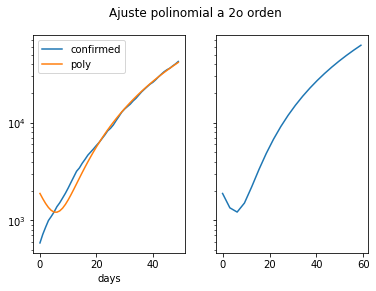

In [71]:
mex = get_country(data, country="Mexico", column="confirmed") # by default returns Mexico
plot_polyfit(mex, column="confirmed", order=2)

Con la normalización a partir de más de 499 casos el comportamiento de México es casi lineal como es de esperarse en la etapa 2. Aproximadamente cada 10 días vamos a tener el doble de casos mientras sigamos con este comportamiento.

In [72]:
def plot_expfit(data, days_plus=5, column="confirmed"):
    x_range = data.index
    y_range = np.log(data[column])

    X = sm.add_constant(x_range)
    y = y_range
    mods = sm.OLS(y, X)

    res = mods.fit()

    a, b = res.params
    y = lambda x: np.exp(a) * np.exp(b) ** x
    x_future = np.linspace(data.index.min(), data.index.max()+days_plus, 20)
    
    plt.plot(x_future, y(x_future), 'r-')
    plt.plot(data.index, data[column], 'b-')
    plt.title("Ajuste exponencial\n(extendido {} días en el futuro)".format(days_plus))
    plt.yscale("log")

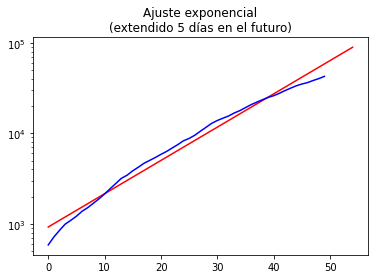

In [73]:
plot_expfit(mex)

Y durante un tiempo el ajuste exponencial va a ser algo malo, aunque creo que mejor que al tomar dia cero a partir del primer caso detectado.

# Playground

In [74]:
other = get_country(data, country="Czechia", column="confirmed") # by default returns Mexico
#plot_polyfit(other)
#other.diff()

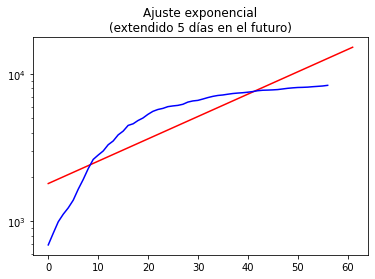

In [75]:
plot_expfit(other)

Terrible ajuste para Rep. Checa.

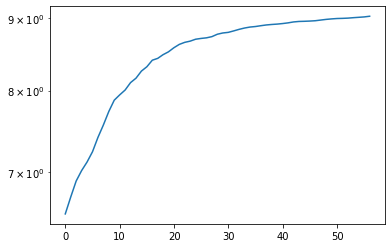

In [76]:
plt.plot(other.index, np.log(other["confirmed"]))
plt.yscale("log")

Esta es la razón por la que el ajuste es malo, no va nada lineal la curva logarítmica.

In [77]:
us = get_country(data, country="US", column="deaths", min_cases=1) # by default returns Mexico
#us = us[us["deaths"] > 0]
#plot_polyfit(us, column="deaths", days_plus=4,order=4)

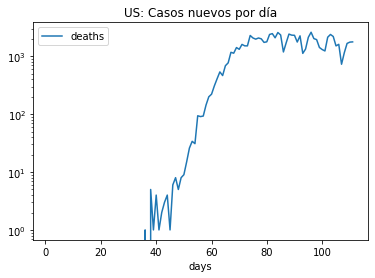

In [78]:
us.diff().plot(title="US: Casos nuevos por día")
plt.yscale("log")

In [79]:
mx = get_country(data, country="Mexico", column="deaths", min_cases=1) # by default returns Mexico`

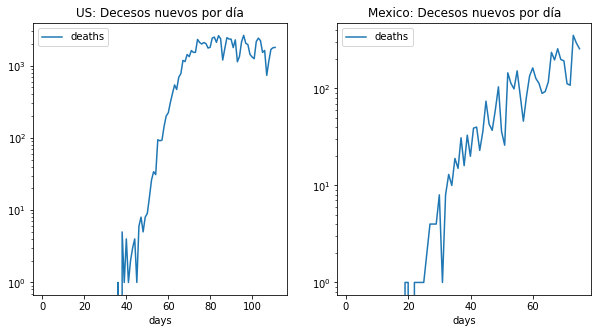

In [80]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
us.diff().plot(title="US: Decesos nuevos por día", ax=ax[0])
mx.diff().plot(title="Mexico: Decesos nuevos por día", ax=ax[1])
for ax in fig.axes:
    plt.sca(ax)
    plt.yscale("log")
    plt.legend()

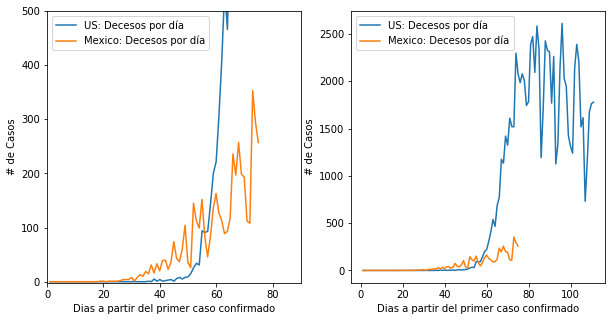

In [93]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(us.diff(), label="US: Decesos por día")
ax[0].plot(mx.diff(), label="Mexico: Decesos por día")
#plt.legend()
ax[0].set_xlim([0,90])
ax[0].set_ylim([-2,500])

ax[1].plot(us.diff(), label="US: Decesos por día")
ax[1].plot(mx.diff(), label="Mexico: Decesos por día")
for ax in fig.axes:
    plt.sca(ax)
    #plt.xticks(rotation=45)
    plt.ylabel("# de Casos")
    plt.xlabel("Dias a partir del primer caso confirmado")
    plt.legend()
    #plt.yscale("log")

A la izq. tenemos un acercamiento de la zona comparable de México con respecto a USA, la segunda es la gráfica completa, vemos que México va "por encima" en decesos, por unos días parecía que se estaba aplanando esta gráfica, pero hoy 15 de abril de 2020 dío un salgo grande con casi 80 nuevos casos, prácticamente el doble de los días anteriores.

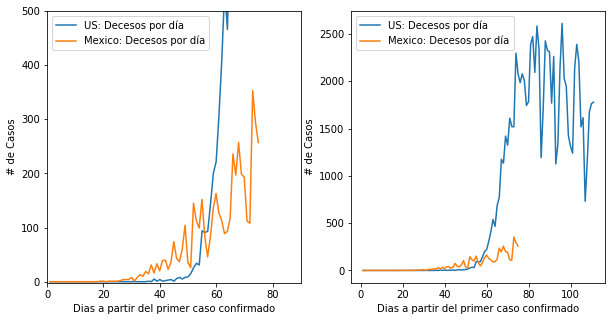

In [91]:
us = get_country(data, country="US", column="deaths", min_cases=1) # by default returns Mexico
mx = get_country(data, country="Mexico", column="deaths", min_cases=1) # by default returns Mexico`
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(us.diff(), label="US: Decesos por día")
ax[0].plot(mx.diff(), label="Mexico: Decesos por día")
#plt.legend()
ax[0].set_xlim([0,90])
ax[0].set_ylim([-2,500])

ax[1].plot(us.diff(), label="US: Decesos por día")
ax[1].plot(mx.diff(), label="Mexico: Decesos por día")
for ax in fig.axes:
    plt.sca(ax)
    #plt.xticks(rotation=45)
    plt.ylabel("# de Casos")
    plt.xlabel("Dias a partir del primer caso confirmado")
    plt.legend()
    #plt.yscale("log")

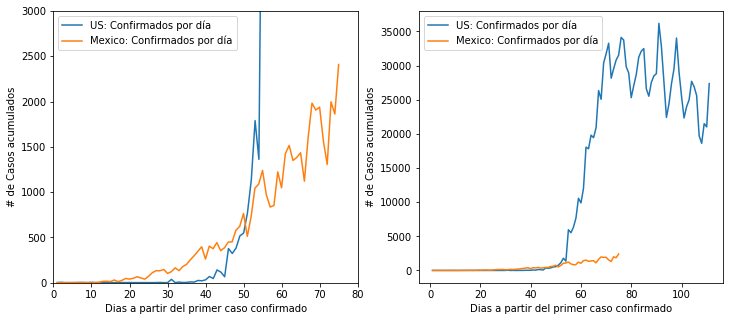

In [83]:
us = get_country(data, country="US", column="confirmed", min_cases=1) # by default returns Mexico
mx = get_country(data, country="Mexico", column="confirmed", min_cases=1) # by default returns Mexico`
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(us.diff(), label="US: Confirmados por día")
ax[0].plot(mx.diff(), label="Mexico: Confirmados por día")
#plt.legend()
ax[0].set_xlim([0,80])
ax[0].set_ylim([-2,3000])

ax[1].plot(us.diff(), label="US: Confirmados por día")
ax[1].plot(mx.diff(), label="Mexico: Confirmados por día")
for ax in fig.axes:
    plt.sca(ax)
    #plt.xticks(rotation=45)
    plt.ylabel("# de Casos acumulados")
    plt.xlabel("Dias a partir del primer caso confirmado")
    plt.legend()
    #plt.yscale("log")

# Mex / Fra

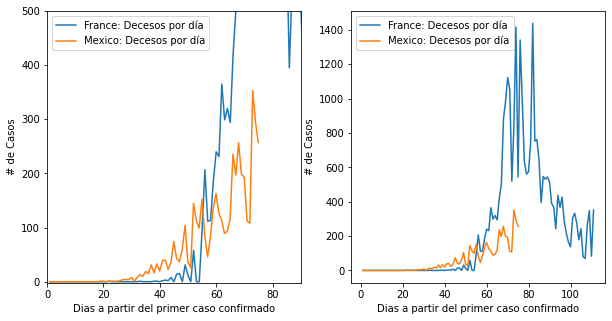

In [90]:
fr = get_country(data, country="France", column="deaths", min_cases=1) # by default returns Mexico
mx = get_country(data, country="Mexico", column="deaths", min_cases=1) # by default returns Mexico`
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(fr.diff(), label="France: Decesos por día")
ax[0].plot(mx.diff(), label="Mexico: Decesos por día")
#plt.legend()
ax[0].set_xlim([0,90])
ax[0].set_ylim([-2,500])

ax[1].plot(fr.diff(), label="France: Decesos por día")
ax[1].plot(mx.diff(), label="Mexico: Decesos por día")
for ax in fig.axes:
    plt.sca(ax)
    #plt.xticks(rotation=45)
    plt.ylabel("# de Casos")
    plt.xlabel("Dias a partir del primer caso confirmado")
    plt.legend()
    #plt.yscale("log")

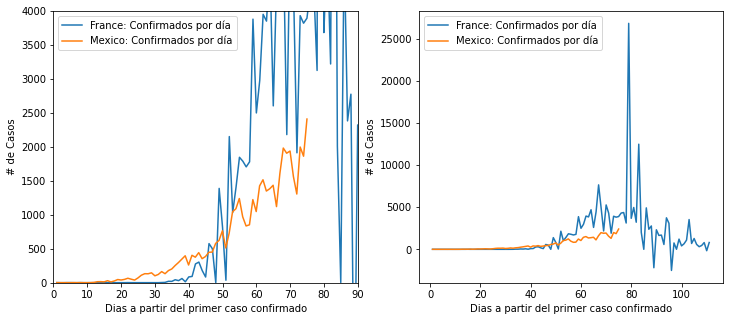

In [85]:
fr = get_country(data, country="France", column="confirmed", min_cases=1) # by default returns Mexico
mx = get_country(data, country="Mexico", column="confirmed", min_cases=1) # by default returns Mexico`
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(fr.diff(), label="France: Confirmados por día")
ax[0].plot(mx.diff(), label="Mexico: Confirmados por día")
#plt.legend()
ax[0].set_xlim([0,90])
ax[0].set_ylim([-2,4000])

ax[1].plot(fr.diff(), label="France: Confirmados por día")
ax[1].plot(mx.diff(), label="Mexico: Confirmados por día")
for ax in fig.axes:
    plt.sca(ax)
    #plt.xticks(rotation=45)
    plt.ylabel("# de Casos")
    plt.xlabel("Dias a partir del primer caso confirmado")
    plt.legend()
    #plt.yscale("log")

In [86]:
fr["diff"] = fr.diff()

In [87]:
fr.tail(30)

,confirmed,diff
days,,
81.958333,133585,3220.0
82.958333,146075,12490.0
83.958333,148084,2009.0
84.958333,148086,2.0
85.958333,153011,4925.0
86.958333,155393,2382.0
87.958333,158168,2775.0
88.958333,155980,-2188.0
89.958333,158303,2323.0


Text(0, 0.5, 'Fecha')

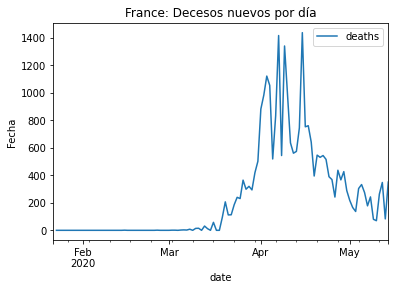

In [88]:
country["France"].diff()[["deaths"]].plot(title="France: Decesos nuevos por día")
plt.ylabel("Casos")
plt.ylabel("Fecha")
#plt.yscale("log")